## Universidade Estadual de Campinas 
## Instituto de Computação
# Trabalho 5 - Explicabilidate
## MO810/MC959 - Tópicos em Inteligência Artificial
## Ética em Aprendizado de Máquina
### Prof. Marcos M. Raimundo
---
### Alunos:
#### Mateus Trentini RA 217290
#### Mauricio Pereira Lopes RA 225242
#### Rita Braga RA 251627
---

In [1]:
# load required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load datasets
df_test = pd.read_excel("../data/processed/test_unfair.xlsx")
df_test.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,11600,50000,1,2,1,57,0,0,-1,0,...,26852,27820,25529,1300,50499,1000,1500,1500,1000,0
1,13821,60000,1,3,2,52,0,0,0,0,...,26305,23756,25353,1500,1500,2000,1500,2000,2000,0
2,18665,80000,2,2,2,28,0,0,0,0,...,50312,44277,44488,2800,2398,2000,2000,1700,2005,0
3,2309,30000,1,2,2,25,0,0,0,0,...,12580,13716,14828,1500,2000,1500,1500,1500,2000,0
4,21597,80000,2,1,2,25,-1,-1,-1,-2,...,0,7240,0,1200,0,0,7240,0,0,1


In [46]:
# setting X and y
X_test = df_test.drop(columns=['ID', 'default payment next month'])
y_test = df_test['default payment next month']

# load pre-trained unbiased explicable model
rf_model = pickle.load(open('../models/best_rf_unf.pkl', 'rb'))

---
## Explain predictions of Random Forest Classifier

In [25]:
# plot entire random forest classifier and save it to a PNG file

import graphviz
from sklearn.tree import export_graphviz

tree_index = 0 # the model has 200 decision trees

dot_data = export_graphviz(rf_model.estimators_[tree_index], 
                           feature_names=X_test.columns.to_list(),
                           class_names=True, 
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
graph.render(filename='../figures/decision_tree', directory='./', cleanup=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.858134 to fit


'../figures/decision_tree.png'

### Feture importance

Feature importance for the model:

1. Feature 'SEX' - Importance: 0.2732
2. Feature 'PAY_0' - Importance: 0.1365
3. Feature 'PAY_2' - Importance: 0.0533
4. Feature 'PAY_AMT1' - Importance: 0.0377
5. Feature 'BILL_AMT1' - Importance: 0.0336
6. Feature 'PAY_4' - Importance: 0.0334
7. Feature 'PAY_3' - Importance: 0.0330
8. Feature 'LIMIT_BAL' - Importance: 0.0315
9. Feature 'BILL_AMT2' - Importance: 0.0304
10. Feature 'PAY_AMT2' - Importance: 0.0300
11. Feature 'BILL_AMT5' - Importance: 0.0285
12. Feature 'BILL_AMT3' - Importance: 0.0284
13. Feature 'BILL_AMT6' - Importance: 0.0283
14. Feature 'PAY_AMT4' - Importance: 0.0281
15. Feature 'BILL_AMT4' - Importance: 0.0279
16. Feature 'PAY_AMT6' - Importance: 0.0267
17. Feature 'PAY_AMT3' - Importance: 0.0266
18. Feature 'AGE' - Importance: 0.0265
19. Feature 'PAY_AMT5' - Importance: 0.0248
20. Feature 'PAY_5' - Importance: 0.0243
21. Feature 'PAY_6' - Importance: 0.0235
22. Feature 'EDUCATION' - Importance: 0.0084
23. Feature 'MARRIAGE' - I

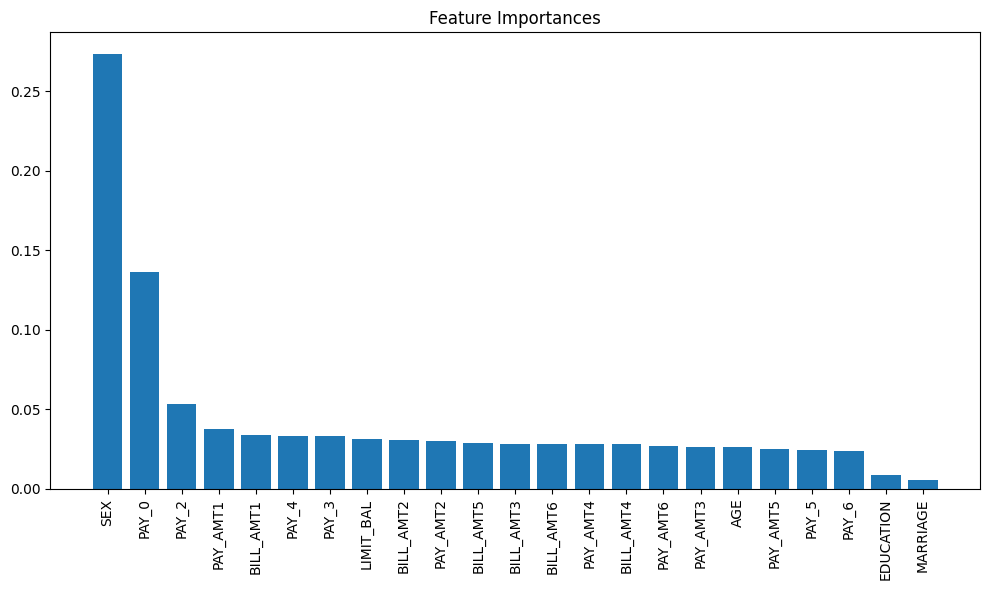

In [26]:
# Get feature importances for the model
importances = rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Display the feature importance
print("Feature importance for the model:\n")
for f in range(len(indices)):
    print(f"{f + 1}. Feature '{feature_names[indices[f]]}' - Importance: {importances[indices[f]]:.4f}")

# Optionally, visualize feature importance (bar plot, for instance)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

### Show decision path for each tree in the Random Forest for one single sample in the test dataset

In [27]:
# Choose a specific sample from the test dataset
sample_index = 16  # Change this index to the desired sample
sample = X_test.loc[sample_index]

feature_names = X_test.columns
#class_names = df_test['default payment next month']

In [28]:
# Get predictions from all trees in the forest for the selected sample
tree_predictions = [tree.predict([sample])[0] for tree in rf_model.estimators_]

# Get the final prediction from the Random Forest
final_prediction = rf_model.predict([sample])[0]

# Identify the decision path leading to the final prediction
decision_path = []
for idx, prediction in enumerate(tree_predictions):
    if prediction == final_prediction:
        tree = rf_model.estimators_[idx]
        nodes = tree.decision_path([sample]).indices
        decision_path.append((nodes, prediction))

# Visualize the decision path
if decision_path:
    print("Decision path for the final classification:")
    for tree_idx, (nodes, predicted_class) in enumerate(decision_path):
        print(f"\nTree {tree_idx + 1} - Predicted Class: {predicted_class}")
        for node in nodes:
            feature = tree.tree_.feature[node]
            if feature != -2:  # Check if it's not a leaf node
                threshold = tree.tree_.threshold[node]
                print(f"  Feature {feature_names[feature]} {'<=' if sample[feature] <= threshold else '>'} {threshold}")
else:
    print("No decision path found for the final classification.")


Decision path for the final classification:

Tree 1 - Predicted Class: 1.0
  Feature PAY_6 <= 1.0
  Feature PAY_5 <= 1.0
  Feature BILL_AMT2 <= 175951.5
  Feature PAY_4 <= -0.5
  Feature EDUCATION <= 1.5
  Feature AGE <= 50.5
  Feature BILL_AMT3 <= 1712.0
  Feature BILL_AMT5 <= 5022.0
  Feature AGE > 27.5

Tree 2 - Predicted Class: 1.0
  Feature PAY_6 <= 1.0
  Feature PAY_AMT4 <= 1500.5
  Feature PAY_0 <= 1.5
  Feature PAY_AMT2 <= 787.0
  Feature LIMIT_BAL > 185000.0
  Feature BILL_AMT6 <= 166.0
  Feature AGE <= 41.5

Tree 3 - Predicted Class: 1.0
  Feature PAY_6 <= 1.0
  Feature PAY_AMT4 <= 1500.5
  Feature PAY_0 <= 1.5
  Feature PAY_AMT2 <= 787.0
  Feature PAY_3 <= 1.0
  Feature AGE <= 49.5
  Feature EDUCATION <= 1.5
  Feature BILL_AMT4 <= 571.5
  Feature AGE <= 54.0

Tree 4 - Predicted Class: 1.0
  Feature PAY_6 <= 1.0
  Feature PAY_AMT4 <= 1500.5
  Feature PAY_0 <= 1.5
  Feature PAY_AMT2 <= 787.0
  Feature PAY_3 <= 1.0
  Feature AGE <= 49.5
  Feature BILL_AMT2 > -108.5
  Feature AG

### For each node in the trees, show how many times each feature was used in the binary split

In [29]:
# Aggregate decision paths leading to the final prediction
aggregated_paths = {}
for idx, prediction in enumerate(tree_predictions):
    if prediction == final_prediction:
        tree = rf_model.estimators_[idx]
        nodes = tree.decision_path([sample]).indices
        for node_idx, node in enumerate(nodes):
            if node_idx not in aggregated_paths:
                aggregated_paths[node_idx] = {}
            feature = tree.tree_.feature[node]
            if feature != -2:  # Check if it's not a leaf node
                aggregated_paths[node_idx].setdefault(feature, 0)
                aggregated_paths[node_idx][feature] += 1

# Display the aggregated paths
print("Aggregated Decision Paths for the final classification:")
for node_idx, features in aggregated_paths.items():
    print(f"Node {node_idx}:")
    for feature, count in features.items():
        print(f"  Feature {feature_names[feature]}: Count - {count}")

Aggregated Decision Paths for the final classification:
Node 0:
  Feature SEX: Count - 27
  Feature PAY_3: Count - 13
  Feature PAY_0: Count - 24
  Feature PAY_2: Count - 14
  Feature PAY_AMT1: Count - 8
  Feature LIMIT_BAL: Count - 8
  Feature PAY_4: Count - 22
  Feature PAY_AMT3: Count - 2
  Feature PAY_5: Count - 13
  Feature PAY_6: Count - 16
  Feature PAY_AMT4: Count - 4
  Feature BILL_AMT6: Count - 1
  Feature PAY_AMT2: Count - 4
  Feature PAY_AMT6: Count - 3
  Feature PAY_AMT5: Count - 1
Node 1:
  Feature PAY_6: Count - 5
  Feature PAY_0: Count - 31
  Feature PAY_3: Count - 17
  Feature PAY_2: Count - 18
  Feature PAY_AMT1: Count - 12
  Feature BILL_AMT2: Count - 2
  Feature PAY_5: Count - 7
  Feature PAY_AMT4: Count - 9
  Feature PAY_AMT2: Count - 11
  Feature SEX: Count - 20
  Feature LIMIT_BAL: Count - 7
  Feature BILL_AMT4: Count - 4
  Feature PAY_4: Count - 9
  Feature PAY_AMT3: Count - 6
  Feature PAY_AMT5: Count - 2
Node 2:
  Feature PAY_AMT4: Count - 16
  Feature PAY_0: 

---
## GAM

In [32]:
# load train dataset
df_train = pd.read_excel("../data/processed/train_unfair.xlsx")

# setting X and y
X_train = df_train.drop(columns=['ID', 'default payment next month'])
y_train = df_train['default payment next month']

In [34]:
import pygam

gam = pygam.LogisticGAM().gridsearch(X_train.values, y_train)

  9% (1 of 11) |##                       | Elapsed Time: 0:00:47 ETA:   0:07:57

did not converge


 18% (2 of 11) |####                     | Elapsed Time: 0:01:06 ETA:   0:02:47

did not converge


 27% (3 of 11) |######                   | Elapsed Time: 0:01:30 ETA:   0:03:14

did not converge


 36% (4 of 11) |#########                | Elapsed Time: 0:02:11 ETA:   0:04:42

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:03:40 Time:  0:03:40


In [38]:
XX = gam.generate_X_grid
pdep, confi = gam.partial_dependence(term = 0, width = .95)

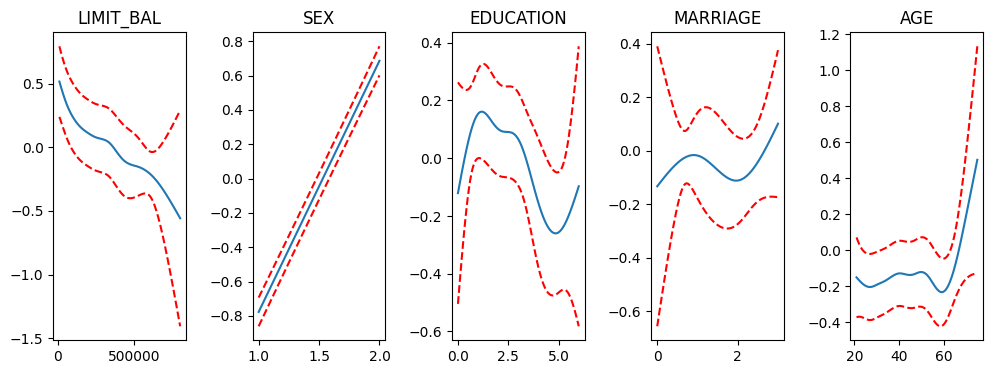

In [45]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4))
titles = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

plt.subplots_adjust(wspace = 0.5)
plt.show()

In [47]:
gam.accuracy(X_test, y_test)

0.6471380471380471

---
## Approximate Models

## Lime

The result cna only be viewed after running the notebook. It is not showed in the GitHub view.

One saved image is available in ../figures/lime-result.png

In [147]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neural_network import MLPClassifier
import lime
from lime import lime_tabular
import time

In [148]:
start_time = time.time()

clf_nn = MLPClassifier(activation = 'logistic', 
                       hidden_layer_sizes = (800, 800, 800),
                       solver = 'adam', 
                       max_iter = 1000, 
                       random_state = 42, verbose = False)

clf_nn.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf_nn.predict_proba(X_test)[:,1])
acc_score = accuracy_score(y_test, clf_nn.predict(X_test))

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

print('\nROC AUC:', roc_auc)
print('Accuracy:', acc_score)

00:01:57

ROC AUC: 0.5456400271265096
Accuracy: 0.5781144781144781


In [162]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data = np.array(X_train),
    feature_names = X_train.columns,
    class_names = ['Good', 'Bad'],
    mode = 'classification')

exp = explainer.explain_instance(
    data_row=X_test.iloc[1],
    predict_fn=clf_nn.predict_proba
)

exp.show_in_notebook(show_table=True)

---
## SHAP

In [140]:
import shap

In [163]:
start_time = time.time()

f = lambda x: clf_nn.predict_proba(x)[:,1]
#the masker shoud be or a function that "erases that feature" or the training dataset that better captures the distribution of the data.
masker = shap.maskers.Independent(data = X_train.values)

explainer = shap.Explainer(f, masker)
shap_values = explainer(X_test)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

PermutationExplainer explainer: 2971it [2:26:11,  2.96s/it]                                                                                               


02:26:12


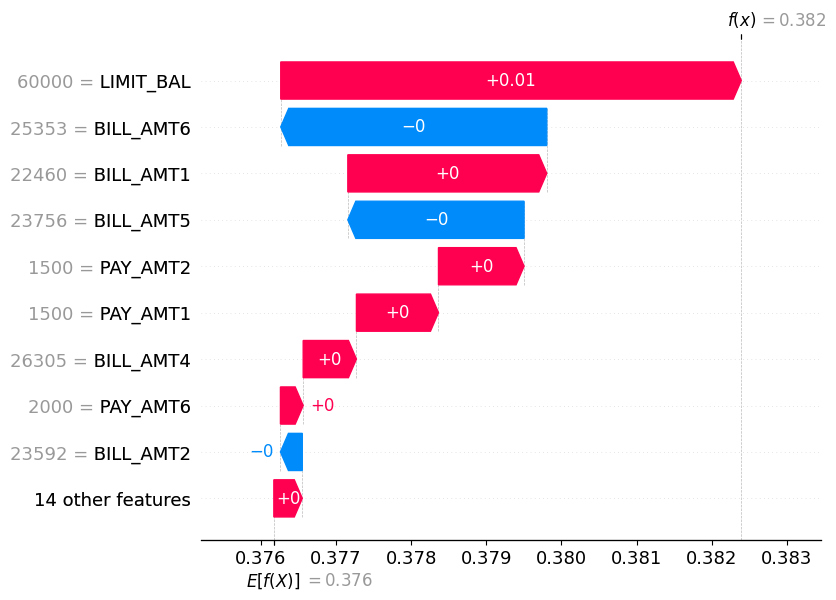

In [164]:
shap.plots.waterfall(shap_values[1])

---
## Partial dependence plots

In [99]:
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
start_time = time.time()

print('Computing partial dependence plots...')
PartialDependenceDisplay.from_estimator(clf_nn, X_train, X_train.columns,
                        n_jobs=3, grid_resolution=1000)
fig = plt.gcf()
fig.set_size_inches(20, 20, forward=True)
fig.subplots_adjust(hspace=1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))